# Flight Arrival Delay Forecasting



##Objectives


*   Create a Notebook instance
*   Use Pandas and Seaborn to visualize Bigquery data

*   Iterate through the analysis process to refine the relationship between departure delays and arrival delays

## Exploratory data analysis in Vertex AI Workbench

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.cloud import bigquery
bq = bigquery.Client()

In [ ]:
%%bigquery
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr

In [ ]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE DEP_DELAY >= 10

sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
ax.axes.set_xlim(-50, 300);

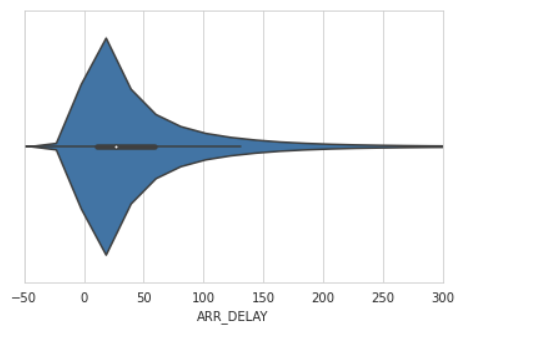

In [ ]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr

In [ ]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

In [ ]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200);

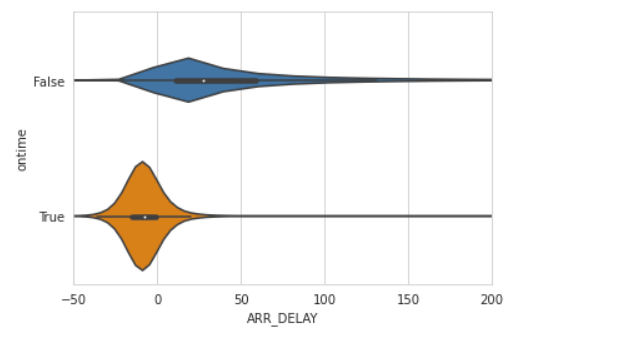

## Quality control

In BigQuery:

```
SELECT
  AVG(ARR_DELAY) AS arrival_delay
FROM
  `dsongcp.flights_tzcorr`
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY
```





```
#standardsql
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `dsongcp.flights_tzcorr`
GROUP BY
  DEP_DELAY
ORDER BY
  DEP_DELAY
```





```
SELECT
  AVG(DEP_DELAY) - 3*STDDEV(DEP_DELAY) AS filtermin,
  AVG(DEP_DELAY) + 3*STDDEV(DEP_DELAY) AS filtermax
FROM
  `dsongcp.flights_tzcorr`
```





```
SELECT
  APPROX_QUANTILES(DEP_DELAY, 20)
FROM
  `dsongcp.flights_tzcorr`
```





```
#standardsql
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  STDDEV(ARR_DELAY) AS stddev_arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `dsongcp.flights_tzcorr`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY
```



In [ ]:
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (
    SELECT COUNT(*) FROM dsongcp.flights_tzcorr
);
CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64>
AS ((
    SELECT AS STRUCT
        THRESH,
        (NUM_TOTAL - SUM(numflights)) AS num_removed,
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2) AS lm
    FROM
    (
        SELECT
            DEP_DELAY,
            AVG(ARR_DELAY) AS arrival_delay,
            STDDEV(ARR_DELAY) AS stddev_arrival_delay,
            COUNT(ARR_DELAY) AS numflights
        FROM
            dsongcp.flights_tzcorr
        GROUP BY
            DEP_DELAY
    )
    WHERE numflights > THRESH
))
;
SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

In [ ]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

## Distribution of arrival delays

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

In [ ]:
depdelay[:5]

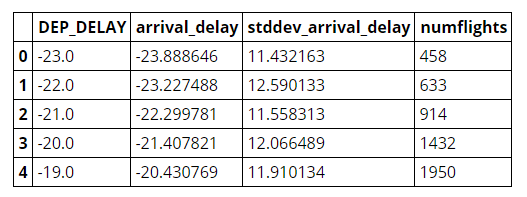

In [ ]:
ax = depdelay.plot(kind='line',
                   x='DEP_DELAY',
                   y='arrival_delay',
                   yerr='stddev_arrival_delay');

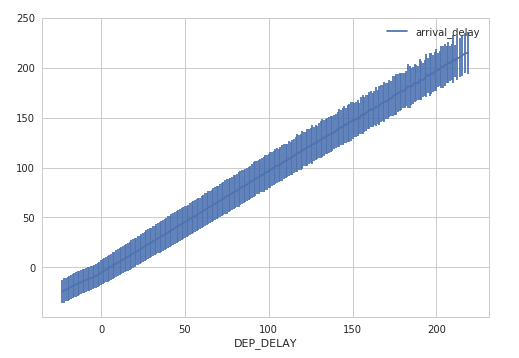

## Applying a probabilistic decision threshold

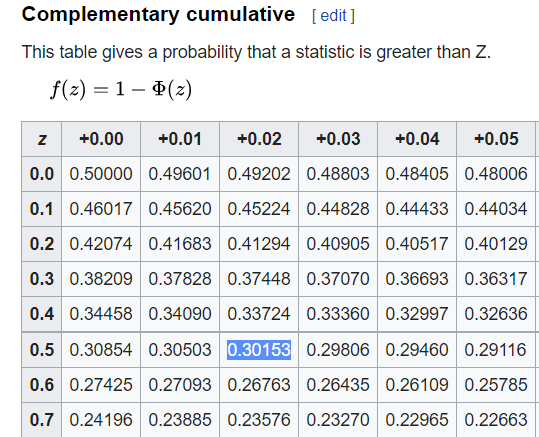

In [ ]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this Arrival Delay (minutes)');
x = np.arange(0, 30)
y = np.ones_like(x) * 15
ax.plot(x, y, color='r');
y = np.arange(0, 30)
x = np.ones_like(y) * 13
ax.plot(x, y, 'g.');

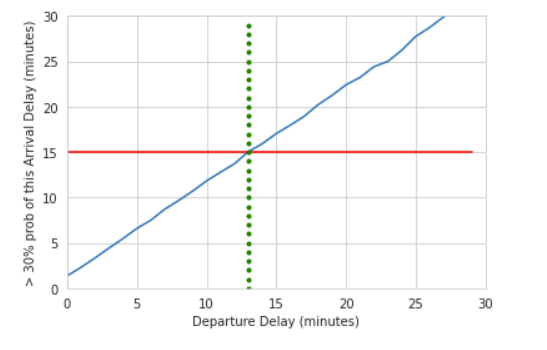

The decision criterion translates to a departure delay of 13 minutes. If the departure delay is 13 minutes or more, the aircraft is more than 30% likely to be delayed by 15 minutes or more.